In [1]:
!pip install yfinance
!pip install numpy_financial
!pip install tiingo


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn
import yfinance as yf
from tiingo import TiingoClient #pip install tiingo se manca il pacchetto su anaconda

capital=100000
config = {}
config['session'] = True
config['api_key'] = "fbb82277db40c7a1924d0a5bcf1d563bd21323cd"
client = TiingoClient(config)
capitale=100000#capitale iniziale

#ticker=["SPY","IJR","TLT"]
#df=yf.download(ticker ,start="2002-08-1",interval='1mo')["Adj Close"]

#df

In [116]:
df=client.get_dataframe(["SPY","IJR","TLT"],frequency='monthly',metric_name='adjClose',startDate='2002-08-01')#scarico i dati
df

,SPY,IJR,TLT
2002-08-30 00:00:00+00:00,60.984344,12.698776,42.472948
2002-09-30 00:00:00+00:00,54.589975,11.958401,44.278872
2002-10-31 00:00:00+00:00,59.081849,12.306342,42.644954
2002-11-29 00:00:00+00:00,62.726079,12.967559,42.254967
2002-12-31 00:00:00+00:00,59.173503,12.536418,44.167951
...,...,...,...
2023-08-31 00:00:00+00:00,446.932518,100.017597,95.120800
2023-09-29 00:00:00+00:00,425.750913,94.079116,87.561371
2023-10-31 00:00:00+00:00,416.508449,88.653585,82.782196
2023-11-30 00:00:00+00:00,454.553936,95.984037,90.991107


In [117]:
df_az=df[["SPY","IJR"]].copy()#copio i dati azionari in un dataframe
df_ob=df["TLT"].copy()#copio i dati obbligazionari in un dataframe


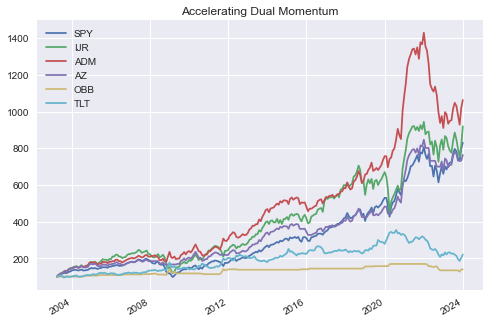

In [118]:
df_az_momentum=(df_az.pct_change()+df_az.pct_change(3)+df_az.pct_change(6)).shift().dropna()#calcolo il momentum a 1,3,6 mesi
df_az_rank=df_az_momentum.rank(axis=1,ascending=False).applymap(lambda x:0 if x>1 else 1)#faccio la classifica per vedere il più forte
df_azionario=(df_az_momentum>0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)#applico il segnale all'azionario
df_obbligazionario=df_azionario.apply(lambda x:1 if x==0 else 0)#applico il segnale opposto all'obbligazionario
df_rendimento_az=((df_az_rank*df_az.pct_change()).sum(axis=1)*df_azionario)
df_rendimento_ob=(df_ob.pct_change()*df_obbligazionario).dropna()#sommo i rendimenti tra azionario e obbligazionario
df_az["ADM"]=((1+(df_rendimento_az+df_rendimento_ob)).cumprod()-1)*capitale+capitale#faccio la produttoria dei rendimenti sui soldi
df_az["AZ"]=((1+(df_rendimento_az)).cumprod()-1)*capitale+capitale
df_az["OBB"]=((1+(df_rendimento_ob)).cumprod()-1)*capitale+capitale
df_az["TLT"]=((1+(df_ob.pct_change())).cumprod()-1)*capitale+capitale
df_az.dropna(inplace=True)#cancello i dati mancanti
df_az=(df_az/df_az.iloc[0])*100#normalizzo a 100
df_az.plot(use_index=True,legend=True,title="Accelerating Dual Momentum")#Plotto la Equity

In [119]:
df_az


,SPY,IJR,ADM,AZ,OBB,TLT
2003-03-31 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2003-04-30 00:00:00+00:00,108.461183,108.570179,108.461183,108.461183,100.000000,101.049440
2003-05-30 00:00:00+00:00,114.408779,116.888937,114.408779,114.408779,100.000000,107.435096
2003-06-30 00:00:00+00:00,115.628619,120.088194,117.540153,117.540153,100.000000,105.497740
2003-07-31 00:00:00+00:00,117.713087,126.067962,123.393042,123.393042,100.000000,94.969934
...,...,...,...,...,...,...
2023-08-31 00:00:00+00:00,783.302566,848.462650,1030.564535,768.785403,134.051002,213.010484
2023-09-29 00:00:00+00:00,746.179277,798.085724,981.722686,732.350129,134.051002,196.082140
2023-10-31 00:00:00+00:00,729.980756,752.060215,928.139413,732.350129,126.734382,185.379807
2023-11-30 00:00:00+00:00,796.660012,814.245416,1020.176280,732.350129,139.301714,203.762581


In [162]:
anni=10
results=pd.DataFrame()
for i1 in range(len(df_az.index)-12*anni):
    i2=i1+12*anni
    t1=df_az.iloc[i1].dropna()
    t2=df_az.iloc[i2].dropna()
    #validi=[x for x in t1.index if x in t2.index]
    results.loc[df_az.index[i1], "SPY"] = ((t2["SPY"]/t1["SPY"])**(1/anni)-1)
    results.loc[df_az.index[i1], "IJR"] = ((t2["IJR"]/t1["IJR"])**(1/anni)-1)
    #results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)*0.80 #!!!Taxes for strategy 20%!!!
    #results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)*0.85 #!!!Taxes for strategy 15%!!!
    #results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)*0.90 #!!!Taxes for strategy 10%!!!
    results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)
    results.loc[df_az.index[i1], "TLT"] = ((t2["TLT"]/t1["TLT"])**(1/anni)-1)

In [163]:
results.describe()

,SPY,IJR,ADM,TLT
count,130.000000,130.000000,130.000000,130.000000
mean,0.106071,0.108210,0.121752,0.058343
std,0.031691,0.023608,0.022519,0.023520
min,0.063633,0.064121,0.076977,-0.001358
25%,0.075270,0.089411,0.105233,0.051134
50%,0.104968,0.105143,0.119042,0.066182
75%,0.134237,0.124908,0.130208,0.072603
max,0.165487,0.181881,0.181448,0.093942


In [164]:
tick_y=["SPY","IJR","ADM","TLT"]



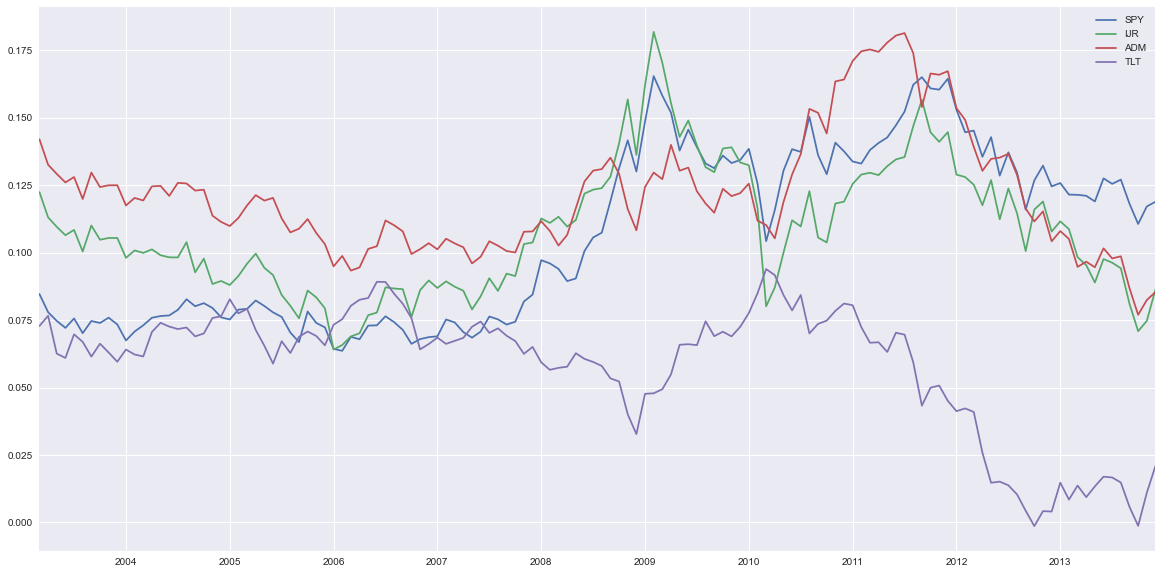

In [165]:
results[tick_y].plot(figsize=(20,10))

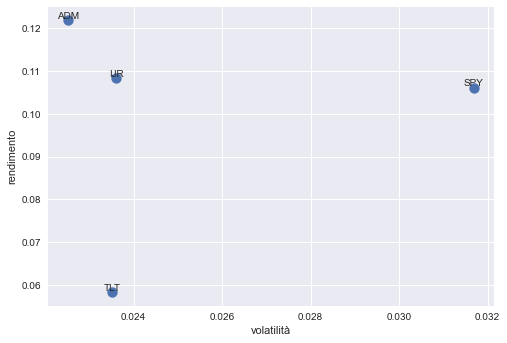

In [166]:
temp=pd.DataFrame([results.mean(),results.std()],index=["rendimento","volatilità"]).transpose()
temp.plot(kind="scatter",x="volatilità",y="rendimento",s=100)
for (xi, yi,zi) in zip(temp["volatilità"],temp["rendimento"],temp.index):
    plt.text(xi, yi, zi, va='bottom', ha='center')

In [167]:
temp

,rendimento,volatilità
SPY,0.106071,0.031691
IJR,0.108210,0.023608
ADM,0.121752,0.022519
TLT,0.058343,0.023520


In [168]:
r_target=0.03
exceed_ret=[results["ADM"].mean()-r_target,results["SPY"].mean()-r_target,results["IJR"].mean()-r_target]
exceed_ret

[0.09175238551055431, 0.07607055811656241, 0.07821046930449822]

In [169]:
tick_a = ["ADM"]  
tick_spy =["SPY"]
tick_ijr =["IJR"]
r_targetD=0.10

downside_returns_a=pd.DataFrame()
sortino_plot=pd.DataFrame()
sortino_index=pd.DataFrame()

# Calculate the downside returns with a r target of 0.1 _a
results_a=results[tick_a]
downside_returns_a = np.minimum(results_a[tick_a], 0.10)
downside_returns_a = downside_returns_a[downside_returns_a['ADM'] != r_targetD]
# Calculate the standard deviation of the downside returns
std_downside_a = np.std(downside_returns_a)

# Calculate the downside returns with a r target of 0.1 _a
results_spy=results[tick_spy]
downside_returns_spy = np.minimum(results_spy[tick_spy], 0.10)
downside_returns_spy = downside_returns_spy[downside_returns_spy["SPY"] != r_targetD]
# Calculate the standard deviation of the downside returns
std_downside_spy = np.std(downside_returns_spy)

# Calculate the downside returns with a r target of 0.1 _a
results_ijr=results[tick_ijr]
downside_returns_ijr = np.minimum(results_ijr[tick_ijr], 0.10)
downside_returns_ijr = downside_returns_ijr[downside_returns_ijr["IJR"] != r_targetD]
# Calculate the standard deviation of the downside returns
std_downside_ijr = np.std(downside_returns_ijr)


downside=[std_downside_a, std_downside_spy, std_downside_ijr]
downside
datasort = {'Downside Dev': [std_downside_a[0],std_downside_spy[0], std_downside_ijr[0]], 'Exceed Return': pd.Series(exceed_ret, index=["ADM", "SPY", "IJR"])}
df_sort=pd.DataFrame(data=datasort, index=["ADM", "SPY", "IJR"])
df_sort





,Downside Dev,Exceed Return
ADM,0.006423,0.091752
SPY,0.007006,0.076071
IJR,0.009055,0.078210


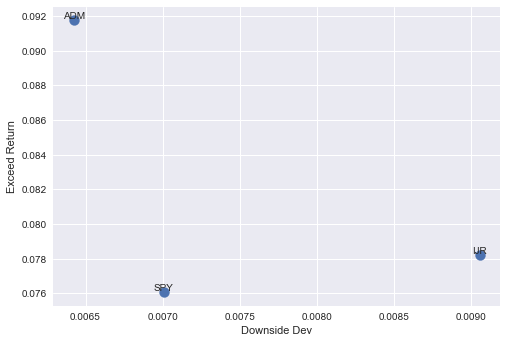

In [170]:
df_sort.plot(kind="scatter",x="Downside Dev",y="Exceed Return",s=100)
for (xi, yi,zi) in zip(df_sort["Downside Dev"],df_sort["Exceed Return"],df_sort.index):
    plt.text(xi, yi, zi, va='bottom', ha='center')

In [171]:
df_sort["Sortino Ratio"]=df_sort["Exceed Return"]/df_sort["Downside Dev"]

In [172]:
df_sort

,Downside Dev,Exceed Return,Sortino Ratio
ADM,0.006423,0.091752,14.283962
SPY,0.007006,0.076071,10.858337
IJR,0.009055,0.078210,8.636992
